This notebook aims to calculate the import risk of COVID-19 in each county in New York, with the formula:


Import risk at time t = <br />
$\sum_{i}$ Confirmed cases of visitor's home county $i$ at time $(t-1)$} $\div$ <br />
population of home county $i$  $\times$ <br />
1 + growth rate of confirmed cases in the previous 7 days $\times$ <br />
(visitors_normalized at last week)


In [1]:
### 1.environment set up ###
import pandas as pd
import numpy as np
import glob 
from os import walk
# absolute path where all data resides
path = "/Users/yezichang/Desktop/NYU/COVID-19/NYU/data"

### 2. read data ###
# 2.1 read confirmed cases data
# returns a list of county names
path_1p3a = path + '/confirmed_cases/1p3a_data'
f = []
for (dirpath, dirnames, filenames) in walk(path_1p3a):
    f.extend(filenames)

# a list of dataframes
dfs = []
for filename in f:
    df = pd.read_csv(dirpath + '/' + filename, header = 0)
    # create a county variable as a string
    df['county'] = [filename[:-4]] * df.shape[0]
    dfs.append(df)
# Concatenate all data into one DataFrame
confirmed_cases = pd.concat(dfs, ignore_index=True)

# 2.2 read travel patterns data
travel_patterns = pd.read_csv(path + '/visitors_patterns/'+ \
                    '2020-03-01-TO-2020-04-26-visitors_home_county_normalized_v0517.csv',
                             header = 0)
# 2.3 read population data
population_by_county = pd.read_csv(path + '/reference/' + \
                                  'population_by_county.csv', header = 0,
                                  thousands=',')
population_density_by_county = pd.read_csv(path + '/reference/' + \
                                          'population_density_by_county.csv', header = 0,
                                          thousands=',')



In [2]:
travel_patterns.sort_values('date')

,Unnamed: 0,date,place_county_code,visitor_county_code,num_visits,num_visitors_nmlz
0,0,2020-03-01,25003,36021,5,0.147059
400,400,2020-03-01,36077,36039,5,0.147059
401,401,2020-03-01,36077,36043,11,0.458333
402,402,2020-03-01,36077,36077,2608,35.936720
403,403,2020-03-01,36077,36095,12,0.126316
...,...,...,...,...,...,...
25774,927,2020-04-26,36047,34017,70,1.223984
25775,928,2020-04-26,36047,34021,8,0.123375
25776,929,2020-04-26,36047,34023,24,0.510163
25768,921,2020-04-26,36047,29095,4,0.166667


In [3]:
# 2.1.1. read jhu data, because it contains the confirmed cases for the entire us

# note that this is in wide format 
confirmed_cases_usa_wide = pd.read_csv(path + '/confirmed_cases/' + \
                                  'confirmed_cases_us_jhu_0515.csv', header = 0)
# drop unnecessary columns
drop_cols = ['UID', 'iso2', 'iso3', 'code3',
             'Admin2', 'Province_State', 'Country_Region', 
             'Lat', 'Long_','Combined_Key',]
confirmed_cases_usa_wide = confirmed_cases_usa_wide.drop(drop_cols, axis = 1)
# melt it to long format, note that the confirmed cases are cumulative cases
dates = confirmed_cases_usa_wide.columns[1:]
confirmed_cases_usa_long = pd.melt(confirmed_cases_usa_wide, \
                                   id_vars = confirmed_cases_usa_wide.columns[0], \
                                   value_vars = dates, \
                                   var_name = 'date', \
                                   value_name = 'confirmed_cases')


In [4]:
confirmed_cases_usa_long.tail()

,FIPS,date,confirmed_cases
375010,NaN,5/15/20,29
375011,NaN,5/15/20,13
375012,NaN,5/15/20,200
375013,NaN,5/15/20,16
375014,NaN,5/15/20,216


In [5]:
### 3. preprocess data ###
# 3.1 Map the county name with fips code
# read the data
fips_map = pd.read_csv(path + '/reference/county_fipcode_mapping_with_dot.csv', 
                      header = None)
# rename the columns
fips_map.columns = ['county', 'state', 'fips']

# filter out the New York States
fips_map = fips_map[fips_map['state'] == 'NY']

# create a dictionary
fips_map_dict = dict(zip(fips_map['county'], fips_map['fips']))

# map it on the confirmed cases dataframe
confirmed_cases['fips'] = confirmed_cases['county'].map(fips_map_dict)

# drop unassigned counties, which returns NULL fips code
confirmed_cases = confirmed_cases[-confirmed_cases['fips'].isna()]


In [6]:
confirmed_cases.head()

,date,confirmed_count,deaths_count,recovered_count,county,fips
0,2020-03-01,0,0,0,Franklin,36033.0
1,2020-03-02,0,0,0,Franklin,36033.0
2,2020-03-03,0,0,0,Franklin,36033.0
3,2020-03-04,0,0,0,Franklin,36033.0
4,2020-03-05,0,0,0,Franklin,36033.0


In [7]:
# 3.2 cumulative sum of the confirmed cases, deaths, recovered
# for col in ['confirmed_count','deaths_count','deaths_count']:
#     confirmed_cases['cum_{}'.format(col)] \
#     = confirmed_cases.groupby(['county','fips'])[col].cumsum()

In [8]:
# for jhu data
# 05/16 update: not necessary for JHU data
# confirmed_cases_usa_long['cum_confirmed_cases'] = \
# confirmed_cases_usa_long.groupby(['FIPS'])['confirmed_cases'].cumsum()

In [9]:
# 3.3 growth rate calculation
def growth_rate_cumulative(df, date_var = 'date', 
                           confirmed_var = 'cum_confirmed_count',
                           groupby_var = ['county', 'fips']):
    # check that the date is datetime type
    df[date_var] = pd.to_datetime( df[date_var])

    # Laplace smoothing confirmed cases with alpha = 1 , to avoid dividing by zero
    df[confirmed_var + "_smooth"] = df[confirmed_var] + 1

    # calculate growth rate in the past 7 days
    df['growth_rate'] = \
    df.groupby(groupby_var) \
    [confirmed_var + "_smooth"].pct_change(periods = 7)
    
    return df

# 1p3a data
# confirmed_cases = growth_rate_cumulative(confirmed_cases)


In [10]:
# calculate growth rate for jhu data 
confirmed_cases_usa_long.columns
confirmed_cases_usa = growth_rate_cumulative(confirmed_cases_usa_long,
                                            date_var = 'date',
                                            confirmed_var = 'confirmed_cases',
                                            groupby_var = ['FIPS'])

In [11]:
confirmed_cases_usa.head()

,FIPS,date,confirmed_cases,confirmed_cases_smooth,growth_rate
0,60.0,2020-01-22,0,1,NaN
1,66.0,2020-01-22,0,1,NaN
2,69.0,2020-01-22,0,1,NaN
3,72.0,2020-01-22,0,1,NaN
4,78.0,2020-01-22,0,1,NaN


In [12]:
### 4. Risk Calculation ### 
# 4.1 calculate empirical probability of infected population
confirmed_join_population = confirmed_cases_usa.merge(population_by_county[['Fipcode','Population']], \
                                                  left_on='FIPS', right_on = 'Fipcode', \
                                                  how='left').drop(['Fipcode'], axis = 1)
# drop na gives out 14720 data records (0.039% )
confirmed_join_population = confirmed_join_population.dropna()
confirmed_join_population['p_confirmed'] = confirmed_join_population['confirmed_cases']/ \
                                        confirmed_join_population['Population'].apply(int)

# 4.3 move the confirmed cases forward for one day
# because we are using yesterday's confirmed cases to estimate today's risk
from datetime import datetime  
from datetime import timedelta
confirmed_join_population['date'] += timedelta(days=1)

In [13]:
confirmed_join_population.tail(5)

,FIPS,date,confirmed_cases,confirmed_cases_smooth,growth_rate,Population,p_confirmed
374896,56037.0,2020-05-16,22,23,0.150000,42343.0,0.000520
374897,56039.0,2020-05-16,99,100,0.010101,23464.0,0.004219
374898,56041.0,2020-05-16,9,10,0.000000,20226.0,0.000445
374899,56043.0,2020-05-16,9,10,0.111111,7805.0,0.001153
374900,56045.0,2020-05-16,0,1,0.000000,6927.0,0.000000


In [14]:
# 4.3 combine with the travel patterns data
travel_patterns['date'] = pd.to_datetime(travel_patterns['date'])
travel_patterns = travel_patterns.rename(columns={"place_county_code":"place_county", \
                                                  "visitor_county_code":"visitors_county"})

# 4.4 the travel patterns data are updated daily,
# so within each week the visitors are the same
travel_patterns_daily = travel_patterns.copy()
travel_patterns_i = travel_patterns.copy()

# identical for the next 6 days
for i in range(6):
    travel_patterns_i['date'] += timedelta(days=1)
    travel_patterns_daily = pd.concat([travel_patterns_daily,travel_patterns_i])
    

In [15]:
travel_patterns_daily.sort_values('date').tail()

,Unnamed: 0,date,place_county,visitors_county,num_visits,num_visitors_nmlz
25775,928,2020-05-02,36047,34021,8,0.123375
25776,929,2020-05-02,36047,34023,24,0.510163
25777,930,2020-05-02,36047,34025,66,0.773251
25769,922,2020-05-02,36047,29097,4,0.012987
27626,2779,2020-05-02,42103,42103,8,0.061069


In [16]:
### 2020.05.17 Update: because the incubation period is 14 days, the effect of the 
### will take effect in 14 days

travel_patterns_daily_daily_sorted = travel_patterns_daily.\
sort_values(by=['date', 'place_county'])

# travel_patterns_daily = travel_patterns_daily.drop(['Unnamed: 0'], axis = 1)

# moving average of num_visits 14 days
num_visits_moving_average_14 = \
travel_patterns_daily.sort_values(by=['date', 'place_county']). \
set_index('date').groupby(['place_county','visitors_county']). \
rolling(14, 7)['num_visits'].mean().reset_index()


# moving average of num_visits_nmlz 14 days
num_visits_nlmz_moving_average_14 = \
travel_patterns_daily.sort_values(by=['date', 'place_county']). \
set_index('date').groupby(['place_county','visitors_county']). \
rolling(14, 7)['num_visitors_nmlz'].mean().reset_index()



In [17]:
num_visits_moving_average_14 = \
num_visits_moving_average_14.rename(columns = \
                                    {'num_visits':'num_visits_movavg_14'})

num_visits_nlmz_moving_average_14 = \
num_visits_nlmz_moving_average_14.rename(columns = \
                                         {'num_visitors_nmlz':'num_visitors_nmlz_movavg_14'})

In [18]:
num_visits_moving_average_14[(num_visits_moving_average_14['place_county'] == 36061) & \
                            (num_visits_moving_average_14['visitors_county'] == 36061)].tail(10)

,place_county,visitors_county,date,num_visits_movavg_14
100013,36061,36061,2020-04-23,51089.142857
100014,36061,36061,2020-04-24,51237.571429
100015,36061,36061,2020-04-25,51386.000000
100016,36061,36061,2020-04-26,48492.071429
100017,36061,36061,2020-04-27,45598.142857
100018,36061,36061,2020-04-28,42704.214286
100019,36061,36061,2020-04-29,39810.285714
100020,36061,36061,2020-04-30,36916.357143
100021,36061,36061,2020-05-01,34022.428571
100022,36061,36061,2020-05-02,31128.500000


In [19]:
travel_patterns_daily_daily_sorted[(travel_patterns_daily_daily_sorted['place_county'] == 36061) & \
                            (travel_patterns_daily_daily_sorted['visitors_county'] == 36061)].tail(10)

,Unnamed: 0,date,place_county,visitors_county,num_visits,num_visitors_nmlz
20899,4310,2020-04-23,36061,36061,55517,1334.651756
20899,4310,2020-04-24,36061,36061,55517,1334.651756
20899,4310,2020-04-25,36061,36061,55517,1334.651756
26290,1443,2020-04-26,36061,36061,6740,176.277218
26290,1443,2020-04-27,36061,36061,6740,176.277218
26290,1443,2020-04-28,36061,36061,6740,176.277218
26290,1443,2020-04-29,36061,36061,6740,176.277218
26290,1443,2020-04-30,36061,36061,6740,176.277218
26290,1443,2020-05-01,36061,36061,6740,176.277218
26290,1443,2020-05-02,36061,36061,6740,176.277218


In [20]:
# join with the travel_patterns_daily_daily_sorted by place_county, visitors_county, and date

travel_patterns_daily_daily_sorted = travel_patterns_daily_daily_sorted. \
drop(['Unnamed: 0'], axis = 1).merge(num_visits_moving_average_14, 
                                    on = ['place_county','visitors_county','date']). \
merge(num_visits_nlmz_moving_average_14, on = ['place_county','visitors_county','date'])

In [21]:
travel_patterns_daily_daily_sorted.head()

,date,place_county,visitors_county,num_visits,num_visitors_nmlz,num_visits_movavg_14,num_visitors_nmlz_movavg_14
0,2020-03-01,25003,36021,5,0.147059,NaN,NaN
1,2020-03-01,29095,29095,106,0.690109,NaN,NaN
2,2020-03-01,29183,29113,5,0.038168,NaN,NaN
3,2020-03-01,29183,29183,40,0.164712,NaN,NaN
4,2020-03-01,29183,29219,5,0.015823,NaN,NaN


In [22]:
# 4.5 we are using the travel data in the week of 03-01 
# to score the risk in the week of 03-08

### 2020.05.17 Update: the date should be the date on which prediction is made
### we should add one more day to align them
travel_patterns_daily_daily_sorted['date'] += timedelta(days=8)
travel_patterns_daily_daily_sorted.tail(5)

,date,place_county,visitors_county,num_visits,num_visitors_nmlz,num_visits_movavg_14,num_visitors_nmlz_movavg_14
193384,2020-05-10,36123,36069,11,0.139860,54.5,1.471350
193385,2020-05-10,36123,36097,4,0.125000,12.0,0.478304
193386,2020-05-10,36123,36101,22,0.709219,163.0,4.828526
193387,2020-05-10,36123,36123,162,3.999813,822.5,22.585107
193388,2020-05-10,42103,42103,8,0.061069,24.0,0.285067


In [23]:
travel_patterns_daily_daily_sorted[
    (travel_patterns_daily_daily_sorted['place_county'] == 36001) 
& (travel_patterns_daily_daily_sorted['visitors_county'] == 36001)].head(10)

,date,place_county,visitors_county,num_visits,num_visitors_nmlz,num_visits_movavg_14,num_visitors_nmlz_movavg_14
33,2020-03-09,36001,36001,16552,162.805700,NaN,NaN
638,2020-03-10,36001,36001,16552,162.805700,NaN,NaN
1243,2020-03-11,36001,36001,16552,162.805700,NaN,NaN
1848,2020-03-12,36001,36001,16552,162.805700,NaN,NaN
2453,2020-03-13,36001,36001,16552,162.805700,NaN,NaN
3058,2020-03-14,36001,36001,16552,162.805700,NaN,NaN
3663,2020-03-15,36001,36001,16552,162.805700,16552.000000,162.805700
4265,2020-03-16,36001,36001,13983,159.410706,16230.875000,162.381326
4809,2020-03-17,36001,36001,13983,159.410706,15981.111111,162.051257
5353,2020-03-18,36001,36001,13983,159.410706,15781.300000,161.787202


In [24]:
# 4.6 join with the confirmed cases table, the confirmed cases in visitors county
confirmed_population_visitors = travel_patterns_daily_daily_sorted.\
merge(confirmed_join_population[['FIPS','date', \
                                 'confirmed_cases','confirmed_cases_smooth',
                                 'growth_rate',\
                                 'p_confirmed', \
                                'Population']], \
      left_on = ['visitors_county','date'],
      right_on=['FIPS','date'], \
      how='left').drop(columns=['FIPS'])

# see a range of values
start_date = pd.to_datetime('2020-03-21')
end_date = pd.to_datetime('2020-05-15')
mask_con_pop_vis = (confirmed_population_visitors['date'] > start_date) &\
(confirmed_population_visitors['date'] < end_date) & (confirmed_population_visitors['visitors_county'] == 36001)\
& (confirmed_population_visitors['place_county'] == 36001)

# sanity check
confirmed_population_visitors[mask_con_pop_vis].tail(5)

,date,place_county,visitors_county,num_visits,num_visitors_nmlz,num_visits_movavg_14,num_visitors_nmlz_movavg_14,confirmed_cases,confirmed_cases_smooth,growth_rate,p_confirmed,Population
179610,2020-05-06,36001,36001,3593,90.316928,19539.5,478.381368,1294.0,1295.0,0.282178,0.004236,305506.0
182390,2020-05-07,36001,36001,3593,90.316928,18277.0,442.223702,1321.0,1322.0,0.237828,0.004324,305506.0
185170,2020-05-08,36001,36001,3593,90.316928,17014.5,406.066035,1348.0,1349.0,0.156947,0.004412,305506.0
187950,2020-05-09,36001,36001,3593,90.316928,15752.0,369.908369,1384.0,1385.0,0.149378,0.004530,305506.0
190730,2020-05-10,36001,36001,3593,90.316928,14489.5,333.750703,1416.0,1417.0,0.143664,0.004635,305506.0


In [25]:
# 4.7 calculate risk by p_confirmed_g * num_visitors_nlz
# growth rate higher, then the risk is higher
confirmed_population_visitors['p_confirmed_growth'] = \
confirmed_population_visitors['p_confirmed']* (1 + confirmed_population_visitors['growth_rate'])

# calculate risk
confirmed_population_visitors['risk'] = \
confirmed_population_visitors['num_visitors_nmlz'] * \
confirmed_population_visitors['p_confirmed_growth'] 

# calculate risk with moving average
confirmed_population_visitors['risk_moving_avg'] = \
confirmed_population_visitors['num_visitors_nmlz_movavg_14'] * \
confirmed_population_visitors['p_confirmed_growth'] 

In [26]:
# calculate risk by density

# join with density

# drop unnecessary columns
population_density_by_county = population_density_by_county[['Fipcode','Population Density']]

# left join with confirmed cases
confirmed_population_visitors = confirmed_population_visitors.\
merge(population_density_by_county, left_on = 'visitors_county',
     right_on = 'Fipcode', how = 'left').drop(['Fipcode'], axis = 1)

confirmed_population_visitors['risk_density_weighted'] = \
confirmed_population_visitors['risk'] *  \
np.log(confirmed_population_visitors['Population Density'])

confirmed_population_visitors['risk_moving_avg_density_weighted'] = \
confirmed_population_visitors['risk_moving_avg'] * \
np.log(confirmed_population_visitors['Population Density'])

In [27]:
confirmed_population_visitors.tail()

,date,place_county,visitors_county,num_visits,num_visitors_nmlz,num_visits_movavg_14,num_visitors_nmlz_movavg_14,confirmed_cases,confirmed_cases_smooth,growth_rate,p_confirmed,Population,p_confirmed_growth,risk,risk_moving_avg,Population Density,risk_density_weighted,risk_moving_avg_density_weighted
193384,2020-05-10,36123,36069,11,0.139860,54.5,1.471350,104.0,105.0,0.129032,0.000947,109777.0,0.001070,0.000150,0.001574,170.442654,0.000769,0.008087
193385,2020-05-10,36123,36097,4,0.125000,12.0,0.478304,7.0,8.0,0.000000,0.000393,17807.0,0.000393,0.000049,0.000188,54.235068,0.000196,0.000751
193386,2020-05-10,36123,36101,22,0.709219,163.0,4.828526,226.0,227.0,0.041284,0.002369,95379.0,0.002467,0.001750,0.011914,68.590352,0.007399,0.050372
193387,2020-05-10,36123,36123,162,3.999813,822.5,22.585107,20.0,21.0,0.105263,0.000803,24913.0,0.000887,0.003549,0.020040,73.676584,0.015260,0.086165
193388,2020-05-10,42103,42103,8,0.061069,24.0,0.285067,427.0,428.0,0.083544,0.007651,55809.0,0.008290,0.000506,0.002363,102.409351,0.002344,0.010940


In [28]:
# 4.8 for each home county, sum the risk from all visitor county
confirmed_population_visitors_grouped = confirmed_population_visitors. \
            groupby(['date','place_county'], \
                    as_index=False)[['num_visits', 
                                     'num_visitors_nmlz', 
                                     'num_visits_movavg_14',
                                     'num_visitors_nmlz_movavg_14',
                                     'growth_rate',
                                     'risk',
                                     'risk_density_weighted',
                                     'risk_moving_avg',
                                     'risk_moving_avg_density_weighted']].mean()

In [29]:
confirmed_population_visitors_grouped.head()

,date,place_county,num_visits,num_visitors_nmlz,num_visits_movavg_14,num_visitors_nmlz_movavg_14,growth_rate,risk,risk_density_weighted,risk_moving_avg,risk_moving_avg_density_weighted
0,2020-03-09,25003,5.000000,0.147059,NaN,NaN,0.0,0.0000,0.000000,NaN,NaN
1,2020-03-09,29095,106.000000,0.690109,NaN,NaN,0.0,0.0000,0.000000,NaN,NaN
2,2020-03-09,29183,16.666667,0.072901,NaN,NaN,0.0,0.0000,0.000000,NaN,NaN
3,2020-03-09,34003,934.500000,9.563811,NaN,NaN,2.0,0.0002,0.001656,NaN,NaN
4,2020-03-09,34013,329.500000,3.033359,NaN,NaN,0.0,0.0000,0.000000,NaN,NaN


In [30]:
### 5. Visualize the risk ### 

# set up environment
import matplotlib.pyplot as plt
import itertools
import seaborn as sns; sns.set()

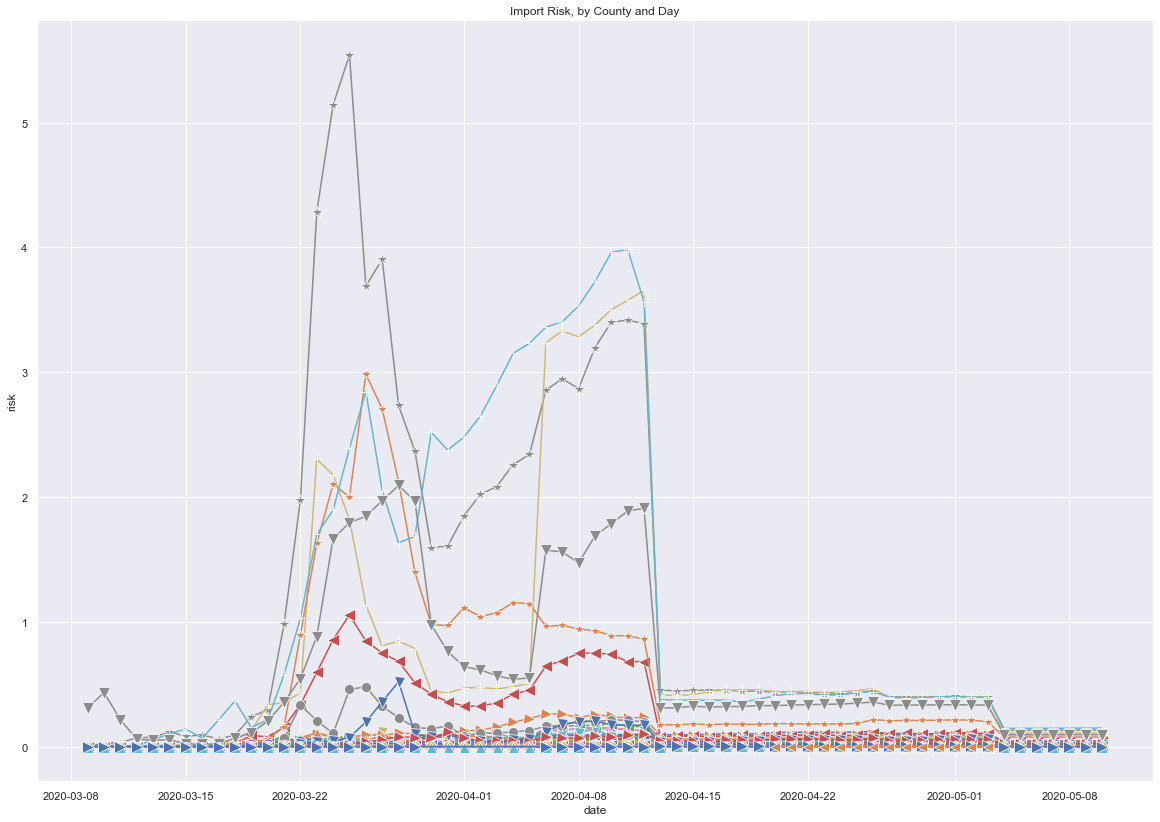

In [31]:
### 5. Visualize the risk ### 

fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))
for key, grp in confirmed_population_visitors_grouped.groupby(['place_county']):
    sns.lineplot(grp['date'],grp['risk'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()
plt.title('Import Risk, by County and Day')
plt.savefig('Import Risk_v0517')

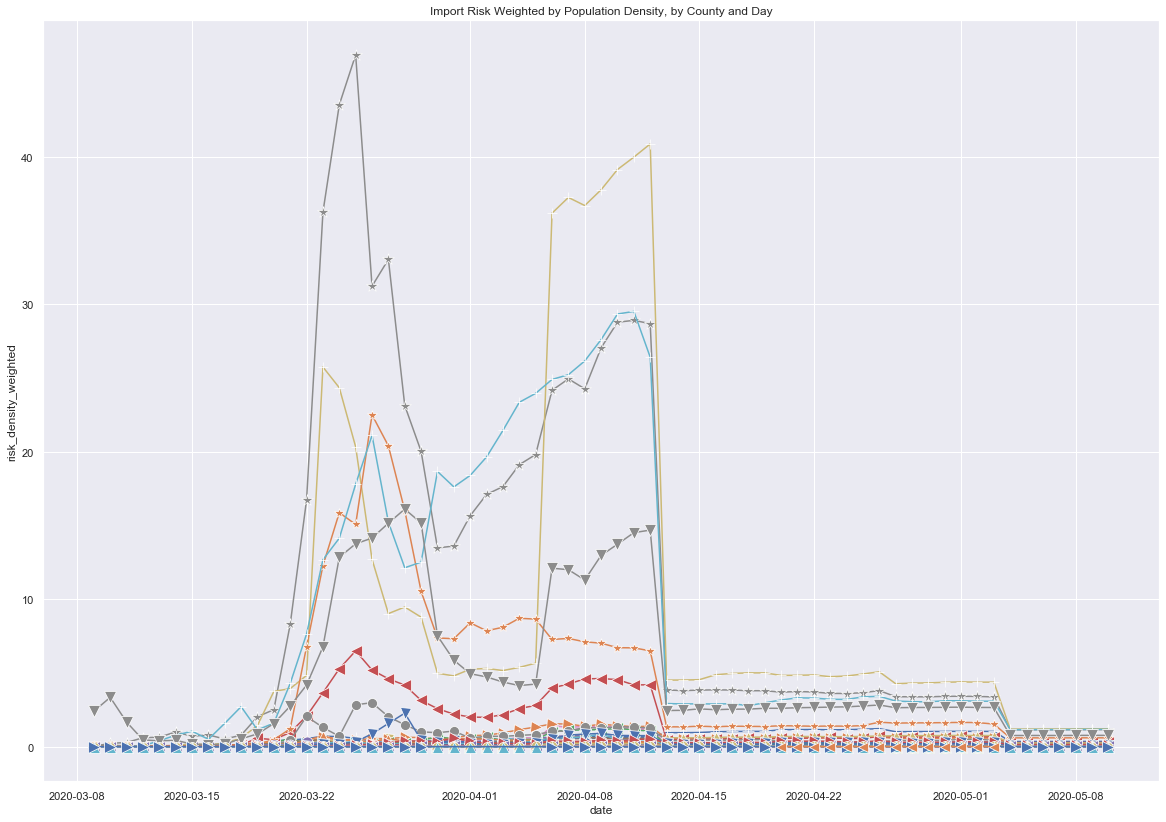

In [32]:
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))
for key, grp in confirmed_population_visitors_grouped.groupby(['place_county']):
    sns.lineplot(grp['date'],grp['risk_density_weighted'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()    
plt.title('Import Risk Weighted by Population Density, by County and Day')
plt.savefig('Import Risk Weighted_v0517')

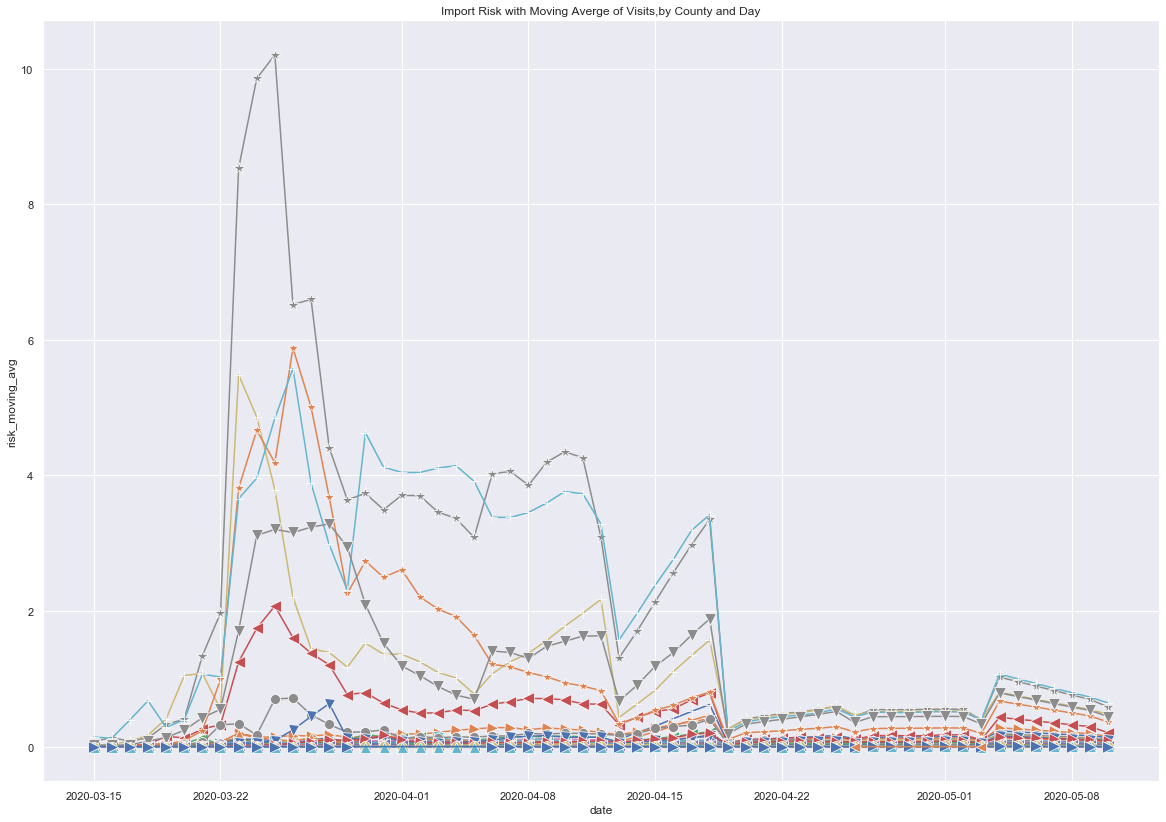

In [33]:
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))
for key, grp in confirmed_population_visitors_grouped.groupby(['place_county']):
    sns.lineplot(grp['date'],grp['risk_moving_avg'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()    
plt.title('Import Risk with Moving Averge of Visits,'+ \
          'by County and Day')
plt.savefig('Import Risk Weighted with Moving Average_v0517')

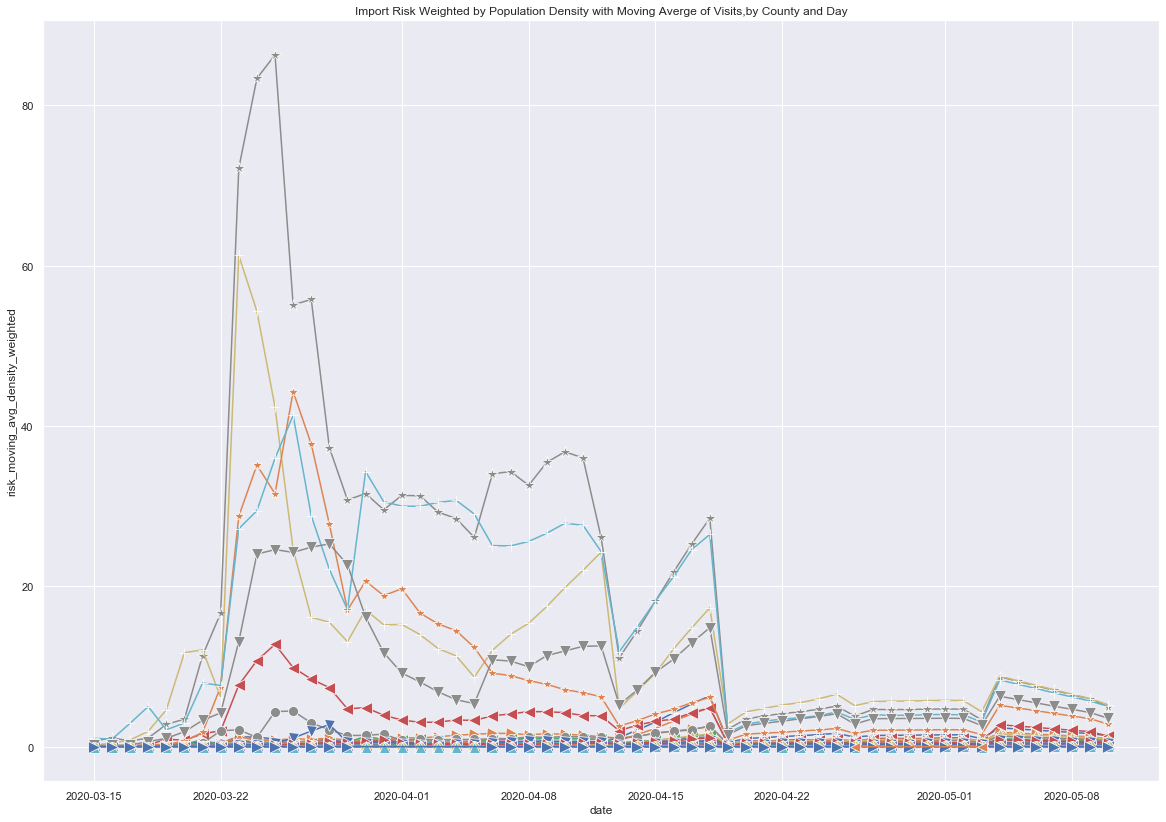

In [34]:
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))
for key, grp in confirmed_population_visitors_grouped.groupby(['place_county']):
    sns.lineplot(grp['date'],grp['risk_moving_avg_density_weighted'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()    
plt.title('Import Risk Weighted by Population Density with Moving Averge of Visits,'+ \
          'by County and Day')
plt.savefig('Import Risk Weighted by Population Density with Moving Average_v0517')

In [35]:
### 6. Join with the Confirmed Cases ### 
confirmed_cases_usa_join_risk = confirmed_cases_usa_long. \
merge(confirmed_population_visitors_grouped, 
      left_on = ['FIPS','date'], right_on = ['place_county','date'],
     how = 'right').drop(['growth_rate_x',
                          'place_county',
                          'num_visits',
                          'num_visitors_nmlz',
                          'growth_rate_y'], axis = 1)
confirmed_cases_usa_join_risk.head()

,FIPS,date,confirmed_cases,confirmed_cases_smooth,num_visits_movavg_14,num_visitors_nmlz_movavg_14,risk,risk_density_weighted,risk_moving_avg,risk_moving_avg_density_weighted
0,25003.0,2020-03-09,1,2,NaN,NaN,0.0000,0.000000,NaN,NaN
1,29095.0,2020-03-09,0,1,NaN,NaN,0.0000,0.000000,NaN,NaN
2,29183.0,2020-03-09,0,1,NaN,NaN,0.0000,0.000000,NaN,NaN
3,34003.0,2020-03-09,4,5,NaN,NaN,0.0002,0.001656,NaN,NaN
4,34013.0,2020-03-09,0,1,NaN,NaN,0.0000,0.000000,NaN,NaN


In [36]:
# confirmed_cases_usa_join_risk.to_csv('riskCalculated_confirmed_cases_v0517.csv')
confirmed_cases_usa_join_risk.to_csv('riskCalculated_confirmed_cases_moving_average_v0517_v2.csv')

In [37]:
confirmed_cases_usa_join_risk.tail()

,FIPS,date,confirmed_cases,confirmed_cases_smooth,num_visits_movavg_14,num_visitors_nmlz_movavg_14,risk,risk_density_weighted,risk_moving_avg,risk_moving_avg_density_weighted
4937,36117.0,2020-05-10,80,81,331.906250,6.251416,0.002188,0.012292,0.007759,0.044016
4938,36119.0,2020-05-10,31294,31295,583.750000,13.028037,0.096259,0.769151,0.444666,3.545926
4939,36121.0,2020-05-10,77,78,157.666667,5.383743,0.002186,0.010711,0.011645,0.054988
4940,36123.0,2020-05-10,21,22,218.600000,6.061811,0.001194,0.005390,0.007267,0.032756
4941,42103.0,2020-05-10,432,433,24.000000,0.285067,0.000506,0.002344,0.002363,0.010940


In [38]:
### Appendix. Debugging ### 
# the spike happens at 04-19, tracking back, it should be the week of 04-12 
confirmed_population_visitors_grouped[
    confirmed_population_visitors_grouped['place_county'] == 36001].head(5)

,date,place_county,num_visits,num_visitors_nmlz,num_visits_movavg_14,num_visitors_nmlz_movavg_14,growth_rate,risk,risk_density_weighted,risk_moving_avg,risk_moving_avg_density_weighted
16,2020-03-09,36001,825.086957,8.216402,NaN,NaN,0.173913,0.000006,0.000032,NaN,NaN
95,2020-03-10,36001,825.086957,8.216402,NaN,NaN,0.173913,0.000006,0.000032,NaN,NaN
174,2020-03-11,36001,825.086957,8.216402,NaN,NaN,0.347826,0.000006,0.000035,NaN,NaN
253,2020-03-12,36001,825.086957,8.216402,NaN,NaN,0.478261,0.000007,0.000039,NaN,NaN
332,2020-03-13,36001,825.086957,8.216402,NaN,NaN,0.869565,0.000153,0.000962,NaN,NaN


In [39]:
# create a boolean crateria for testing
start_date = pd.to_datetime('2020-04-01')
end_date = pd.to_datetime('2020-04-15')
mask = (confirmed_population_visitors['date'] > start_date) &\
(confirmed_population_visitors['date'] <= end_date) & (confirmed_population_visitors['place_county'] == 36001)

In [40]:
confirmed_population_visitors[mask][confirmed_population_visitors['place_county'] == 36001].to_csv('36001-0416-0425.csv')

/Users/yezichang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [41]:
mask_grouped =  (confirmed_population_visitors_grouped['date'] > start_date) & (confirmed_population_visitors_grouped['date'] <= end_date)

In [42]:
confirmed_population_visitors_grouped[mask_grouped]

,date,place_county,num_visits,num_visitors_nmlz,num_visits_movavg_14,num_visitors_nmlz_movavg_14,growth_rate,risk,risk_density_weighted,risk_moving_avg,risk_moving_avg_density_weighted
1860,2020-04-02,29183,13.000000,0.090909,19.928571,0.103975,6.230769,0.000152,0.001000,0.000174,0.001144
1861,2020-04-02,34003,202.500000,3.085927,448.285714,5.626948,4.051019,0.050179,0.412002,0.090525,0.747820
1862,2020-04-02,34013,126.000000,2.404296,248.714286,3.191918,4.924084,0.040324,0.352966,0.053534,0.468593
1863,2020-04-02,34017,98.500000,1.767254,259.857143,3.323032,5.622961,0.036599,0.350291,0.068974,0.660683
1864,2020-04-02,34019,30.000000,0.474187,79.928571,0.949680,3.538462,0.002025,0.011484,0.004055,0.022999
...,...,...,...,...,...,...,...,...,...,...,...
2930,2020-04-15,36117,124.333333,2.395821,509.916071,8.641769,0.540422,0.002401,0.013583,0.007234,0.039092
2931,2020-04-15,36119,505.617347,11.724422,1852.941176,40.423559,0.583377,0.325269,2.565750,1.187559,9.294349
2932,2020-04-15,36121,156.578947,5.169616,205.242857,6.724814,0.706569,0.006859,0.033175,0.008302,0.038009
2933,2020-04-15,36123,68.966667,1.759191,315.500000,7.876105,0.732689,0.002304,0.011201,0.008182,0.035028


In [43]:
confirmed_population_visitors_grouped.columns

Index(['date', 'place_county', 'num_visits', 'num_visitors_nmlz',
       'num_visits_movavg_14', 'num_visitors_nmlz_movavg_14', 'growth_rate',
       'risk', 'risk_density_weighted', 'risk_moving_avg',
       'risk_moving_avg_density_weighted'],
      dtype='object')

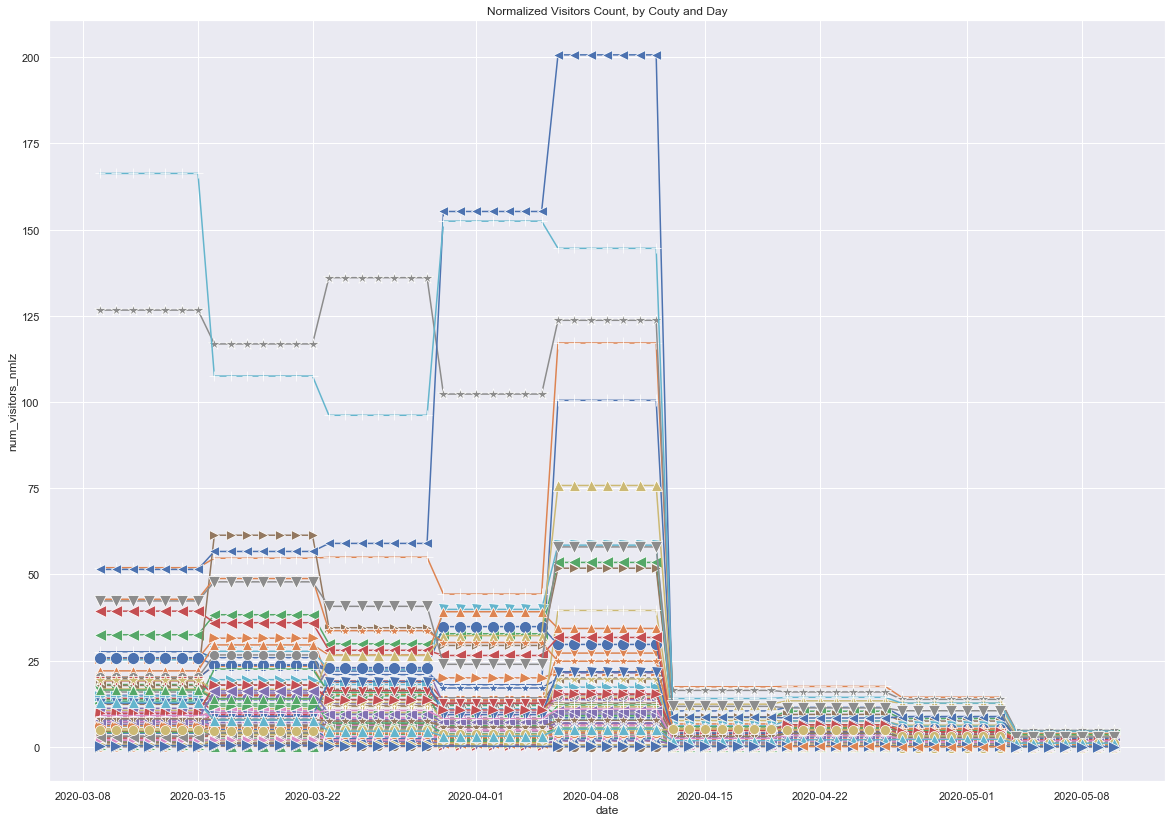

In [44]:
import matplotlib.pyplot as plt
import itertools
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))

for key, grp in confirmed_population_visitors_grouped.groupby(['place_county']):
    sns.lineplot(grp['date'],grp['num_visitors_nmlz'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()
plt.title('Normalized Visitors Count, by Couty and Day')
plt.savefig('Visitors Normalized_v0517')

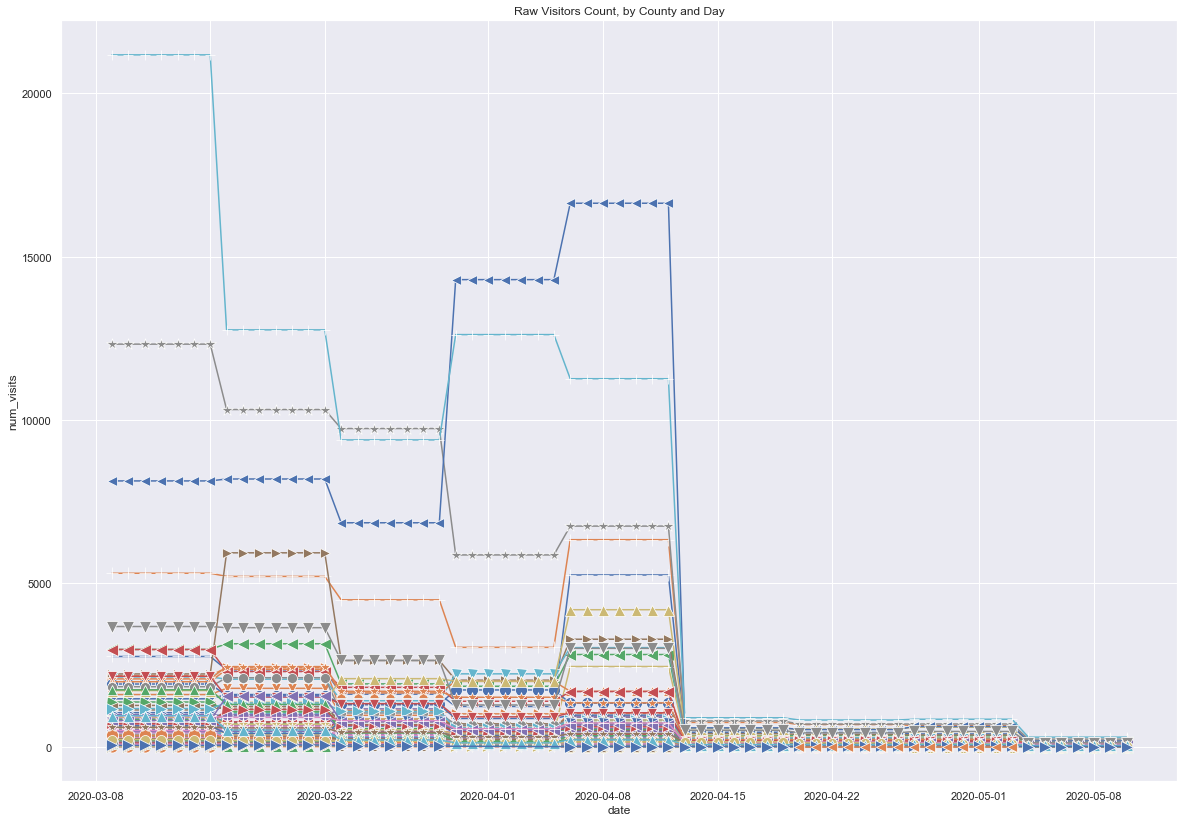

In [45]:
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))

for key, grp in confirmed_population_visitors_grouped.groupby(['place_county']):
    sns.lineplot(grp['date'],grp['num_visits'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()
plt.title('Raw Visitors Count, by County and Day')
plt.savefig('Visitors Raw_v0517')

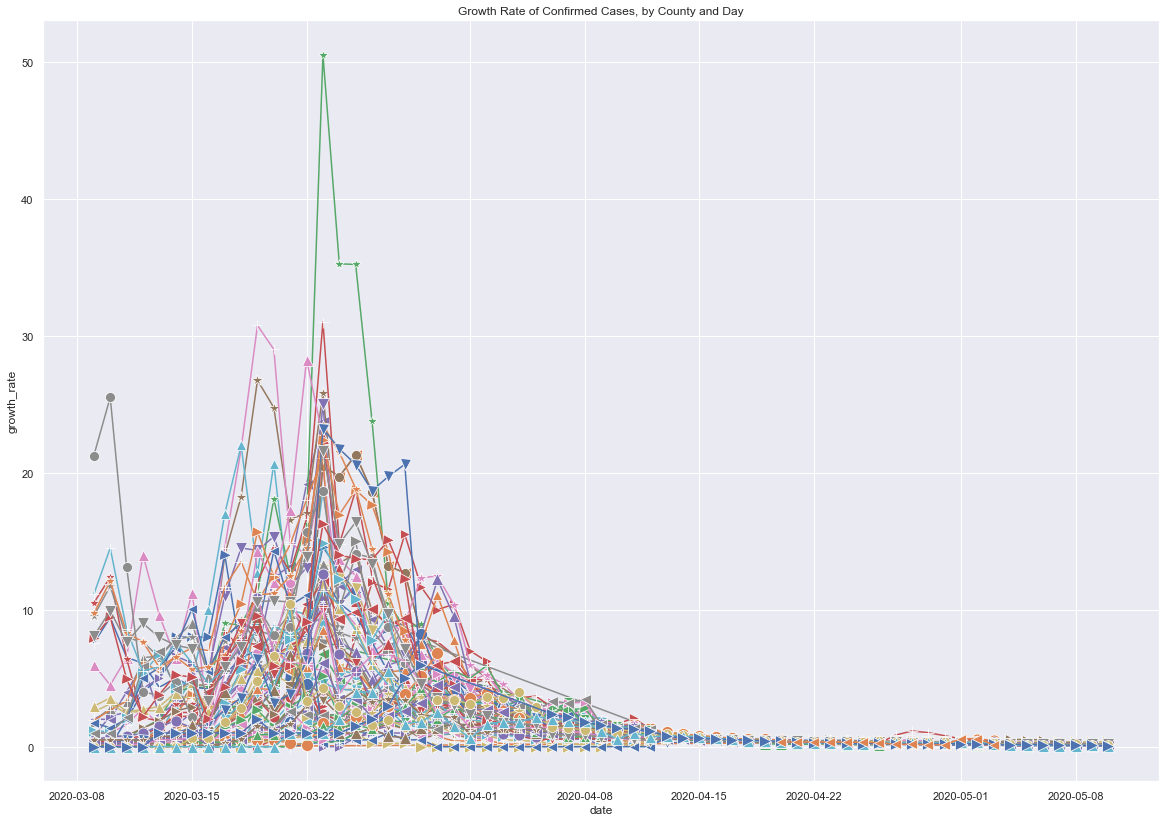

In [46]:
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))

for key, grp in confirmed_population_visitors_grouped.groupby(['place_county']):
    sns.lineplot(grp['date'],grp['growth_rate'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()
plt.title('Growth Rate of Confirmed Cases, by County and Day')
plt.savefig('Growth Rate_v0517')

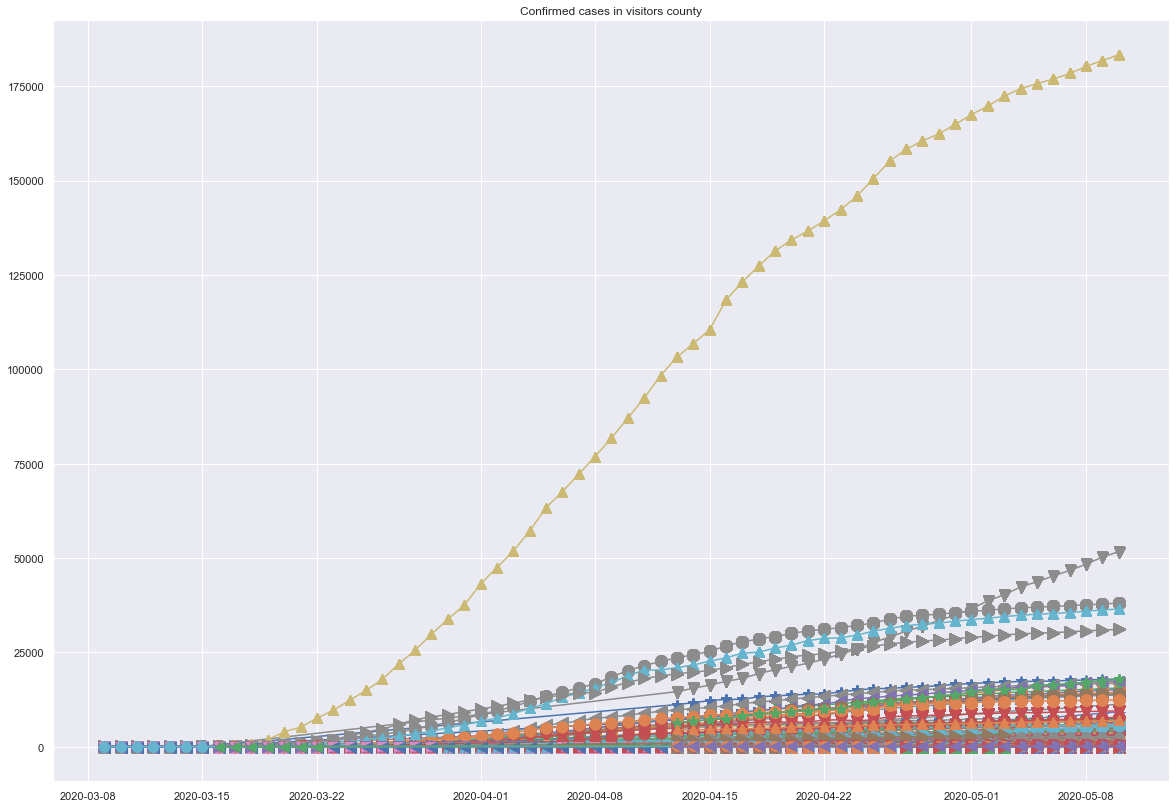

In [47]:
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))
for key, grp in confirmed_population_visitors.groupby(['visitors_county']):
    ax2.plot(grp['date'],grp['confirmed_cases'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
plt.title('Confirmed cases in visitors county')
plt.savefig('Confirmed cases in visitors county_v0517')

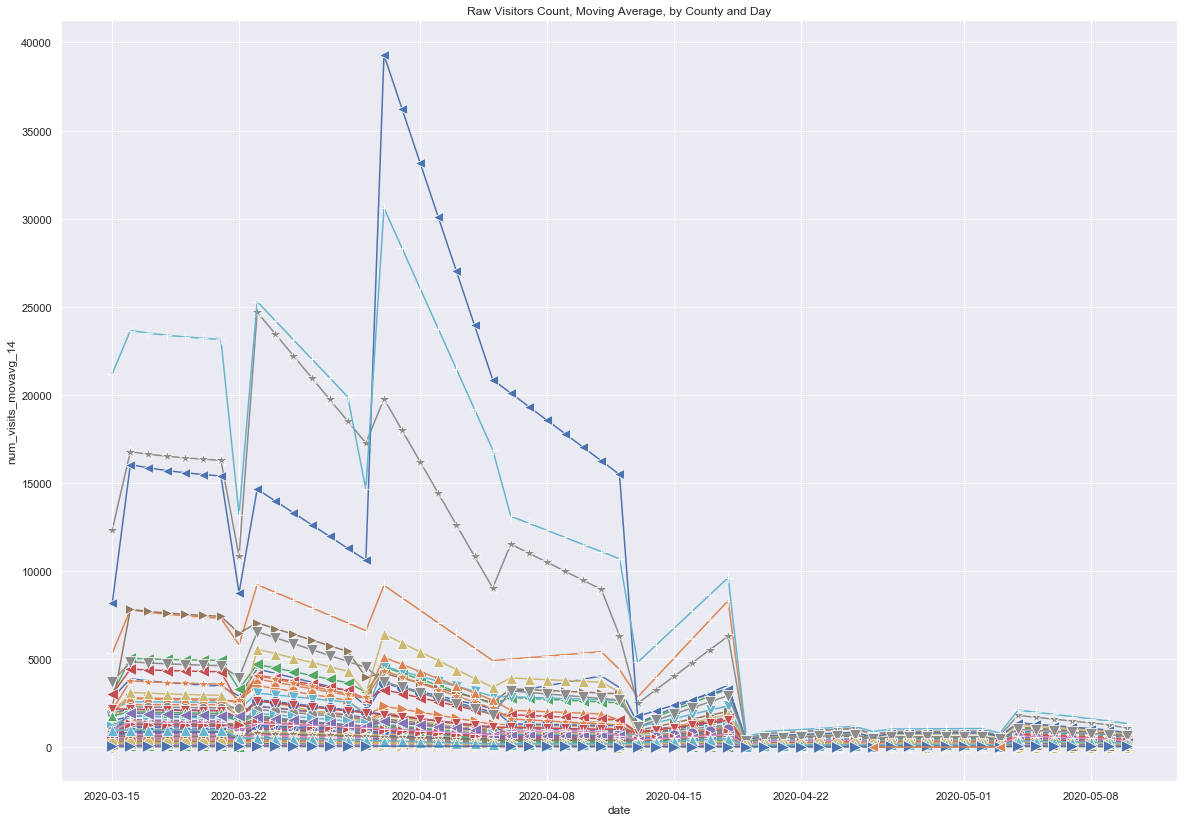

In [48]:
# moving average num visits
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))

for key, grp in confirmed_population_visitors_grouped.groupby(['place_county']):
    sns.lineplot(grp['date'],grp['num_visits_movavg_14'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()
plt.title('Raw Visitors Count, Moving Average, by County and Day')
plt.savefig('Visitors Raw, Moving Average_v0517')

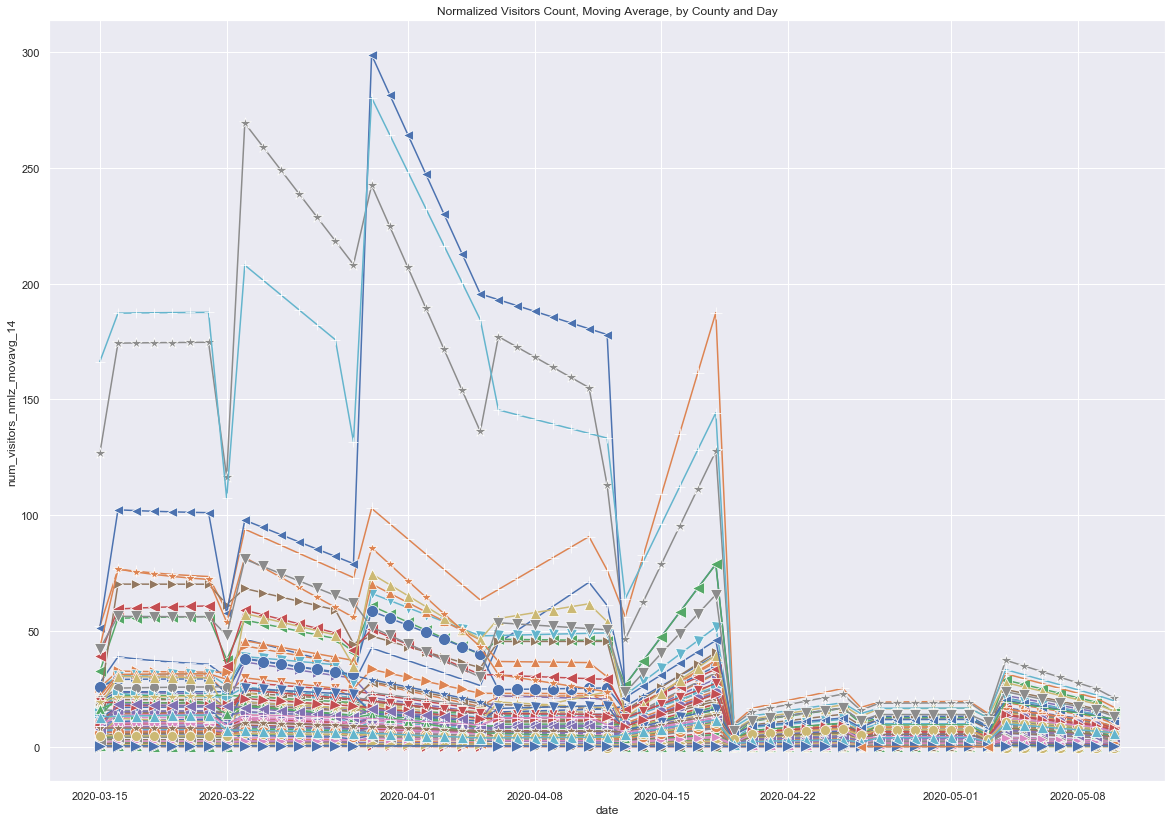

In [49]:
# m
fig, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (20,14))
marker = itertools.cycle(('v', 'o', '^','>','<','*','+'))
size= itertools.cycle(tuple(range(10,13)))

for key, grp in confirmed_population_visitors_grouped.groupby(['place_county']):
    sns.lineplot(grp['date'],grp['num_visitors_nmlz_movavg_14'], label = key, marker = next(marker), linestyle='-',
            markersize = next(size))
ax2.get_legend().remove()
plt.title('Normalized Visitors Count, Moving Average, by County and Day')
plt.savefig('Normalized Visitors Count, Moving Average_v0517')